# Overfitting and Underfitting in ANNs

For all their performance power, ANNs are not without their shortcomings. Four such issues described earlier were:

* Vanishing/Exploding gradients
* Insufficient training data
* Extremely slow training
* Overfitting

This lab will cover the last of these: **overfitting**. Overfitting happens across every problem addressed by machine learning/deep learning and ANNs are no difference. Learning the methods to reduce/eliminate overfitting are important for anyone interested in developing their acumen in the field.

When building a model to solve a problem, the model is typically "trained" using historical data on the given phenomenon so that predictions can be made when new data becomes available. This is a balancing act between **model optimization** and **model generalization**. Optimization can be thought of as what's done during the training process -- evaluating several models, hyperparameter optimization, etc. On the other hand, generalization is the expectation/goal that the trained model will perform well making predictions on new, unseen data. Good generalization is the goal of building models but it isn't something that can be directly controlled.

Initial training occurs using **Training Data** and then evaluated using **Test Data** which simulates data that might be passed through the model in the future. Both come from the same data set originally with observations randomly being assigned to one set or the other. When beginning to train a model and compare the predictions it makes both to the training data and testing data, at first the predictive performance will improve within both data sets. If a model's training was *stopped* very early on this would be a case of **underfitting** -- the model has not been allowed to identify all the patterns in the training data useful for the prediction task. In other words, it could do better!

By contrast, overfitting occurs when training is allowed for too long. Eventually, the model is starting to learn patterns that are specific to the training data but might be irrelevant or misleading when using it on the test data. The goal then is to find a preverbial "Goldilocks Zone" for model complexity.

The ideal solution to overfitting is to obtain more training data (which it itself is another issue with ANNs) but that isn't always possible. Two approaches outlined below, **regularization** and **dropout**, can be used when obtaining more data isn't feasible. To get started, the code below loads the (IMDB dataset)[https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset] from **TensorFlow's** high-level API **tf.keras**. This is a commonly used data set for benchmarking *sentiment analysis* models. Be sure to read the data set information provided in the link as it will help moving forward.

In [30]:
# Import IMDB data set and NumPy
from tensorflow.keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# Function to create a matrix for vectorizing each review
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
y_train = np.asarray(train_labels).astype('float32')

# Our vectorized test data
x_test = vectorize_sequences(test_data)
y_test = np.asarray(test_labels).astype('float32')

## Steps to combat overfitting

### Reducing the network's size

When architecting an ANN, each additional layer added gives the network more opportunities to learn more elaborate patterns within the training data. However, this increase in **capacity** (as it's called in deep learning) comes at a cost: overfitting. This is because the additional parameters give the ANN the ability to *memorize* the patterns in the training data as they relate to their targets/labels. This effectively reduces the model's ability to generalize to new data which is the goal of developing thee models in the first place!

Conversely, if the capacity of the network is kept arbitrarily small, it will not be able to learn the function that maps input data to output data well which essentially leads to underfitting. Finding the "Goldilocks Zone" is one of the most challenging aspects of deep learning!

Sadly, there isn't a formula that will determine the optimal number of layers and neurons within each layer for any given problem. The best approach is trial-and-error. Below, a simple *Sequential()* ANN is designed for classifying each IMDB film review as either positive or negative.


In [28]:
# Import tf.keras functions and design benchmark ANN
from tensorflow.keras import models
from tensorflow.keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

For the sake of comparison, another ANN will also be made. Both networks are the same number of layers, but this one has fewer neurons per layer (16 vs. 4).

In [39]:
# Design ANN with 4 neurons per layer
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

Each ANN is trained using the same training hyperparameters with each model's loss reported (lower loss is better as it indicates an ANN making fewer misclassifications).

In [36]:
# Train benchmark ("original") ANN
original_hist = original_model.fit(x_train, 
                                   y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 162us/sample - loss: 0.4665 - acc: 0.8187 - val_loss: 0.3497 - val_acc: 0.8803
Epoch 2/20
25000/25000 [==============================] - 2s 92us/sample - loss: 0.2697 - acc: 0.9081 - val_loss: 0.3138 - val_acc: 0.8753
Epoch 3/20
25000/25000 [==============================] - 2s 92us/sample - loss: 0.2072 - acc: 0.9275 - val_loss: 0.2811 - val_acc: 0.8886
Epoch 4/20
25000/25000 [==============================] - 2s 94us/sample - loss: 0.1722 - acc: 0.9396 - val_loss: 0.3221 - val_acc: 0.8725
Epoch 5/20
25000/25000 [==============================] - 2s 89us/sample - loss: 0.1497 - acc: 0.9484 - val_loss: 0.3058 - val_acc: 0.8814
Epoch 6/20
25000/25000 [==============================] - 2s 97us/sample - loss: 0.1288 - acc: 0.9575 - val_loss: 0.3246 - val_acc: 0.8772
Epoch 7/20
25000/25000 [==============================] - 2s 88us/sample - loss: 0.1143 - acc: 0.9618 - val_loss: 0

In [40]:
# Train "smaller" ANN
smaller_model_hist = smaller_model.fit(x_train, 
                                       y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 3s 123us/sample - loss: 0.6380 - acc: 0.6226 - val_loss: 0.5971 - val_acc: 0.6914
Epoch 2/20
25000/25000 [==============================] - 2s 78us/sample - loss: 0.5549 - acc: 0.7725 - val_loss: 0.5377 - val_acc: 0.8063
Epoch 3/20
25000/25000 [==============================] - 2s 80us/sample - loss: 0.4964 - acc: 0.8424 - val_loss: 0.4994 - val_acc: 0.8057
Epoch 4/20
25000/25000 [==============================] - 2s 75us/sample - loss: 0.4536 - acc: 0.8787 - val_loss: 0.4678 - val_acc: 0.8563
Epoch 5/20
25000/25000 [==============================] - 2s 74us/sample - loss: 0.4212 - acc: 0.9024 - val_loss: 0.4498 - val_acc: 0.8608
Epoch 6/20
25000/25000 [==============================] - 2s 72us/sample - loss: 0.3950 - acc: 0.9174 - val_loss: 0.4380 - val_acc: 0.8672
Epoch 7/20
25000/25000 [==============================] - 2s 71us/sample - loss: 0.3727 - acc: 0.9285 - val_loss: 0

After training both models, training performance (as evaluated using the validation data) can be graphed and compared. 

In [38]:
# Import matplotlib for visualizing validation performance
import matplotlib.pyplot as plt

# Set range of epochs to plot and extract validation losses from each ANN
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

# Plot the validation loss for each ANN
plt.figure(figsize=(15,10))
plt.plot(epochs, original_val_loss, 'r+', label='Benchmark model')
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

NameError: name 'smaller_model_hist' is not defined

Comparing the two ANNs, it's clear that smaller network begins overfitting (i.e. validation loss begins to rise) later than the ANN with more neurons.

After comparing the two, the next ANN dramatically increases the capacity over the first two ANNs by constructing layers with 512 neurons each.

In [7]:
# Train "bigger" ANN
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

bigger_model_hist = bigger_model.fit(x_train, 
                                     y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

When comparing the new "bigger" ANN with the original, it becomes clear that the bigger model starts overfitting almost immediately. Not only that, but the training process is rather "bumpy" with sudden jumps in validation loss -- particularly around epoch 7 and 10.

In [8]:
# Extract "bigger" model validation loss
bigger_model_val_loss = bigger_model_hist.history['val_loss']

# Plot the validation loss for each ANN
plt.figure(figsize=(15,10))
plt.plot(epochs, original_val_loss, 'r+', label='Benchmark model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

Remember, this chart is visualizing the loss on the *validation* data set which acts as a stand-in for the final data set we'll use to evaluate the model -- the *test set*. That's because, just like the test set, the model is *not* trained using the validation set either. This is supposed to give a better estimation of how the model will perform on new, unseen data.

Conversely, the performance of the model when making predictions on the training data (i.e. the same data the model was trained on) should be very good.

In [9]:
# Extract training set loss from each ANN
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

# Plot the training loss for each ANN
plt.figure(figsize=(15,10))
plt.plot(epochs, original_train_loss, 'r+', label='Benchmark model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

As expected, the bigger model drops the training set loss to near zero very quickly whereas the original model is much more gradual. The lesson here is that the greater a model's capacity, the quicker it will be able to model the training data, but the more susceptible it will be to overfitting which is noted by the large difference between training and validation loss.

### Adding weight regularization

One of the driving tenents within the deep learning and machine learning world is called the *Law of Parsimony,* sometimes called "Occam's Razor." It states that the optimal approach for building models is to strive for the simplest one that gets the job done effectively. This accomplishes two tasks:
* It's easier to explain how a simpler model works compared to a complex one. This becomes very important in highly-regulated industries that require model explination.
* They are harder to overfit. As seen above and discussed earlier, as an ANN becomes more complex not only is it getting more power to learn useful patterns in the training data, it's also becoming more capable of memorizing patterns specific to the training data and therefore decreasing generalizability.

A common way to mitigate overfitting is to put constraints on the complexity of an ANN by forcing its weights to only take on small values, which makes the distribution of weight values more "regular". This is called **weight regularization**, and it is done by adding to the loss function of the network a *penalty* associated with large weight values. The two major approaches to regularization are:

* **L1 Regularization** sums together the absolute value of the ANN's weights (called the *L1 Norm*) and applies a penalization term.
* **L2 Regularization** sums together the squared value of the ANN's weights (called the *L2 Norm*) and applies a penalization term. L2 regularization is also called *weight decay* in the context of ANNs. 

In tf.keras, weight regularization is added by passing the `kernel_regularizer=` argument to each layer of the ANN. Below, a L2 regularizer is added to each layer.

In [45]:
# Import regularizers
from tensorflow.keras import regularizers

# Train ANN with L2 Regularization applied
l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

l2_model_hist = l2_model.fit(x_train, 
                             y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))                 

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 153us/sample - loss: 0.4929 - acc: 0.8232 - val_loss: 0.3798 - val_acc: 0.8812
Epoch 2/20
25000/25000 [==============================] - 3s 103us/sample - loss: 0.3180 - acc: 0.9057 - val_loss: 0.3417 - val_acc: 0.8854
Epoch 3/20
25000/25000 [==============================] - 2s 93us/sample - loss: 0.2725 - acc: 0.9194 - val_loss: 0.3523 - val_acc: 0.8775
Epoch 4/20
25000/25000 [==============================] - 2s 96us/sample - loss: 0.2508 - acc: 0.9284 - val_loss: 0.3632 - val_acc: 0.8742
Epoch 5/20
25000/25000 [==============================] - 2s 97us/sample - loss: 0.2423 - acc: 0.9312 - val_loss: 0.3453 - val_acc: 0.8835
Epoch 6/20
25000/25000 [==============================] - 2s 98us/sample - loss: 0.2348 - acc: 0.9346 - val_loss: 0.3629 - val_acc: 0.8782
Epoch 7/20
25000/25000 [==============================] - 2s 99us/sample - loss: 0.2298 - acc: 0.9364 - val_loss: 

In the above ANN architecture, the `kernel_regularizer=regularizers.l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight value` to the total loss of the network. Note that because this penalty is only added at training time, the loss for this network will be much higher at training than testing.

The impact of L2 regularization can be seen below when comparing this model with the benchmark.

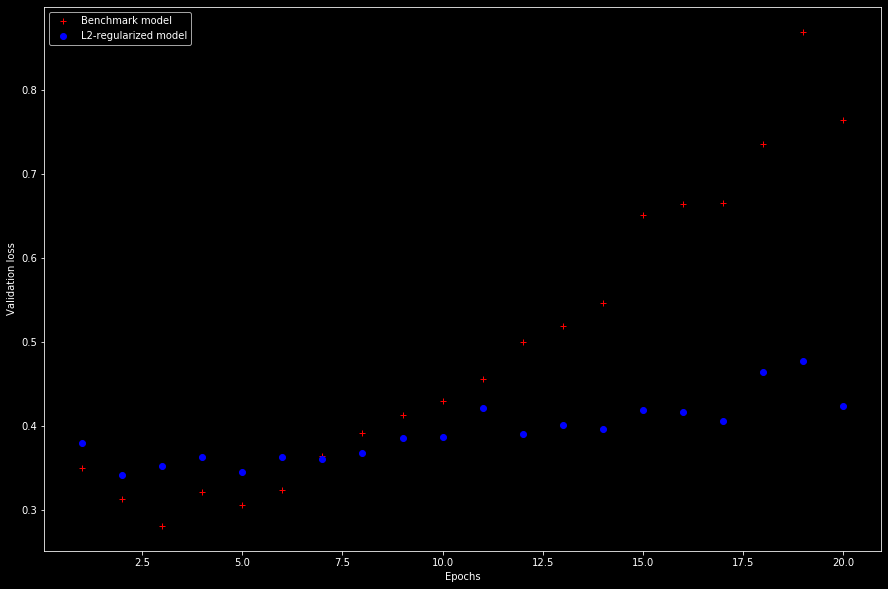

In [46]:
# Extract L2 regularization model validation loss
l2_model_val_loss = l2_model_hist.history['val_loss']

# Plot the training loss for each ANN
plt.figure(figsize=(15,10))
plt.plot(epochs, original_val_loss, 'r+', label='Benchmark model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

When regularization is added the validation loss is far more resistant to overfitting than before. Loss does still increase over epochs, but at a much slower rate than before. Below, L1 regularization is shown as well as **ElasticNet** which is a combination of L1 and L2 regularization. Compare all three and plot their loss against the benchmark ANN in the Exercise section below.

```
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)
```

### Adding dropout

In machine learning and deep learning sometimes some features can contribute more to a solution than others. When left unchecked, models can be trained to become very reliant on those features rather than incorporating information from all of them together. ANNs also can exhibit a similar problem where neurons become excedingly more and more important to the network's predictions. An ANN that utilizes all of its connections and doesn't favor one over another is optimal and preferrable.

**Dropout** is one of the most effective and most commonly used regularization techniques for neural networks. Dropout, applied to a layer, consists of randomly "turning off the signal" (i.e. output) to a number of neurons in a layer during training. Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 1.3, 0, 1.1]`. The **dropout rate** is the proportion of neurons to "turn off" (values between 0.2 and 0.5 are typical). During testing, all neurons are left "on" and instead the layer's output values are scaled down by a factor equal to the dropout rate. This counter-balances the fact that all neurons are active now than at training time.

Below, a randomly-generated matrix of values between 0 and 0.1 is created (similar to the weight coefficients seen in an ANN). At training time, since a proportion of neurons will be effectively "turned off," the remaining neurons will, in essence, be forced to learn more features in the data. This means their output signal will be much stronger than what it would be if *all* the ANN's neurons were allowed to learn with each epoch. Therefore, the output signal needs to be scaled down at the same rate as the dropout rate:

In [26]:
# Import NumPy and random
import random
import numpy as np

# Create 4x4 matrix of random floats
layer_output=[]

for n in range(16):
    layer_output.append(random.uniform(0, 0.1))

layer_output = np.reshape(layer_output, (4, 4))

# At training time we drop out 50% of the units in the output
layer_output *= np.random.randint(0, 2, layer_output.shape)

# Output signal adjustment can be applied during training rather than during testing
layer_output /= 0.5

Why does dropout work to inhibit overfitting? Computer scientist Geoff Hinton, the developer of the technique, indicated his inspiration for dropout came from visiting his bank. He noticed that tellers were constantly being switched around and changing. When asking an employee, they stated that they believed it was to prevent collusion between employees attempting to defraud the bank. This was apparently enough to give Hinton the insight to how dropout could improve ANN training and prevent overfitting.

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present. 

In tf.keras, dropout is added to a network via the `Dropout` layer, which gets applied to the output of layer right before it. Below, dropout is added to the first two layers of the benchmark ANN trained earlier.

In [31]:
# Add dropout to benchmark ANN and train
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 159us/sample - loss: 0.5974 - acc: 0.6750 - val_loss: 0.4481 - val_acc: 0.8641
Epoch 2/20
25000/25000 [==============================] - 2s 92us/sample - loss: 0.4405 - acc: 0.8124 - val_loss: 0.3326 - val_acc: 0.8823
Epoch 3/20
25000/25000 [==============================] - 2s 95us/sample - loss: 0.3536 - acc: 0.8609 - val_loss: 0.2912 - val_acc: 0.8880
Epoch 4/20
25000/25000 [==============================] - 3s 106us/sample - loss: 0.3000 - acc: 0.8920 - val_loss: 0.2773 - val_acc: 0.8883
Epoch 5/20
25000/25000 [==============================] - 3s 114us/sample - loss: 0.2583 - acc: 0.9090 - val_loss: 0.2835 - val_acc: 0.8872
Epoch 6/20
25000/25000 [==============================] - 3s 114us/sample - loss: 0.2294 - acc: 0.9207 - val_loss: 0.2979 - val_acc: 0.8861
Epoch 7/20
25000/25000 [==============================] - 3s 115us/sample - loss: 0.2092 - acc: 0.9291 - val_los

As before, the new ANN with dropout can be compared to the benchmark to see when overfitting begins.

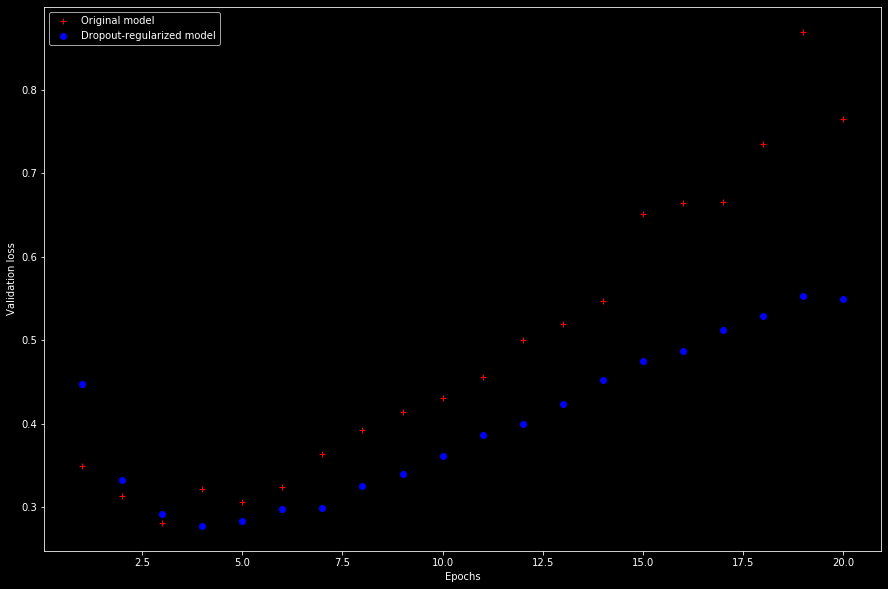

In [42]:
# Extract training set loss from ANN
dpt_model_val_loss = dpt_model_hist.history['val_loss']

# Plot the validation loss for each ANN
plt.figure(figsize=(15,10))
plt.plot(epochs, original_val_loss, 'r+', label='Benchmark model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

While it seems that overfitting is still occuring after several epochs, compared to the benchmark ANN overfitting is rather contained. What about comparing the dropout ANN to the L2 regularization ANN?

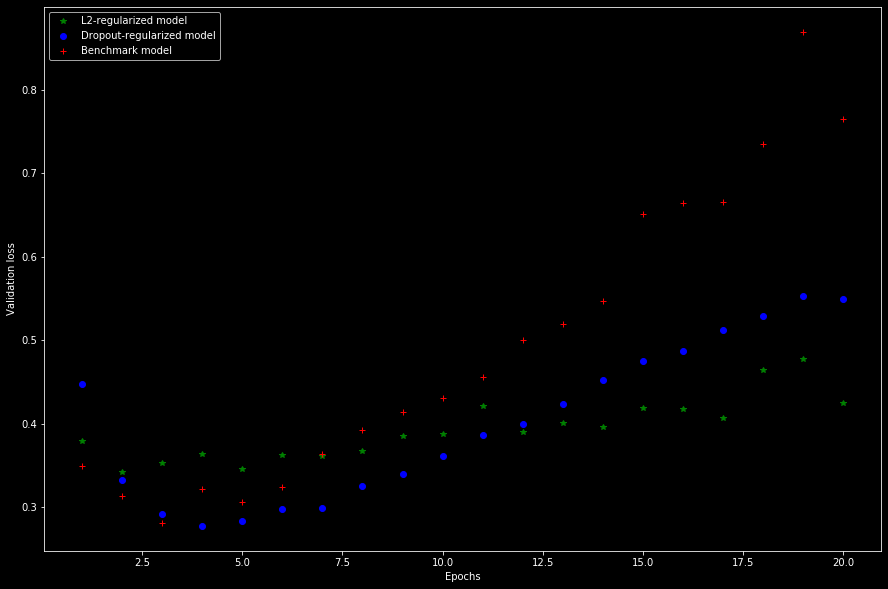

In [48]:
# Plot the validation loss for each ANN
plt.figure(figsize=(15,10))
plt.plot(epochs, l2_model_val_loss, 'g*', label='L2-regularized model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.plot(epochs, original_val_loss, 'r+', label='Benchmark model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

# Exercise

Create a ANN for classifying

In [52]:
import tensorflow_datasets as tfds

from kaggle.api.kaggle_api_extended import KaggleApi

ModuleNotFoundError: No module named 'kaggle'